In [18]:
import pylab as plb
import scipy as sy
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import numpy as np
import math

In [42]:
### Overview
# Four regimes exist as a combination of a hydrological cycle and exogenous source:
# IDN + Met
# IDN + IDP
# COL + Met
# COL + IDP
# The terms are abbreviated as follows: 
# IDN (Intermediate drying), COL (continuous wet), these have different mean annual precipitation and seasonal amplitudes
# Met (meteorite source), IDP (Interplanetary Dust Particle source), these have different survival fractions


plt.clf()

### Variable Declarations
w_i = 60.7e-9         # Mass fraction of organics in incoming interplanetary dust (IPD)
m_dot_I = 6e8         # IPD mass flux to Earth [kg/yr]
f_s = 0.32            # Survival fraction of organics during atmospheric entry
r = 40.               # Characteristic pond catchment radius [m]
rho = 2185.           # Density of rocky ejecta [kg/m^3]
r_p = 1.              # Pond radius [m]
A_p = math.pi*r_p**2  # Pond surface area [m^2]
r_g = 500.            # Gravitational settling length scale [m]

# Ponds evaporate at different rates when the water level is at a different depth
tau_d_1cm = 4.9e-3    # Drying timescale for a 1 cm water layer [yr]
tau_d_5cm = 0.12      # Drying timescale for a 5 cm layer [yr]
tau_d_10cm = 0.48     # Drying timescale for a 10 cm layer [yr]

R_plus = 6371000
gamma = 31557600      # Seconds per year
rho_w = 1000.         # Water density [kg/m^3]

# Temperature of experiments (conversion from C to K)
T_50 = (273.15+50)
T_65 = (273.15+65)
T_80 = (273.15+80)

molecules = {
    "Adenine": {"mu": 0.13513, "rho": 1470, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Guanine": {"mu": 0.15113, "rho": 2200, "Ea": 6330, "B": 9.40}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Uracil": {"mu": 0.1120868, "rho": 1320, "Ea": 7649, "B": 11.76}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Cytosine": {"mu": 0.1111, "rho": 1550, "Ea": 5620, "B": 8.69}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Thymine": {"mu": 0.1261133, "rho": 1230, "Ea": 7709, "B": 11.24}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "2-Amino-oxazole": {"mu": 0.084077, "rho": 1200, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Ribose": {"mu": 0.15013, "rho": 800, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Formaldehyde": {"mu": 0.030031, "rho": 815, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Xanthine": {"mu": 0.15211, "rho": 1600, "Ea": 6230, "B": 9.42}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "Hypoxanthine": {"mu": 0.1361115, "rho": 2000, "Ea": 5270, "B": 7.95}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "HCN": {"mu": 0.0270253, "rho": 687, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": parent_flux_red, "ox": parent_flux_ox}},
    "H2CO": {"mu": 0.030031, "rho": 815, "Ea": 5902, "B": 8.15}, #"parent_mu": mu_HCN, "parent_flux": {"red": 6.01494508e-12, "ox": 1.15285175e-09}}
}

### Hydrolysis rate constants
# Arrhenius rate constants for hydrolysis different molecules at T= 50, 65, 85 C
# def hydrolysis_rate(Ea, T, B):
#     return 10**(-Ea/T + B)

k_i_50 = 10**(-5902/T_50 + 8.15)   # all species at T = 50
k_A_65 = 10**(-5902/T_65 + 8.15)   # adenine
k_i_80 = 10**(-5902/T_80 + 8.15)   # all species at T = 85
k_G_65 = 10**(-6330/T_65 + 9.40)   # guanine
k_U_65 = 10**(-7649/T_65 + 11.76)  # uracil
k_C_65 = 10**(-5620/T_65 + 8.69)   # cytosine
k_T_65 = 10**(-7709/T_65 + 11.24)  # thymine
k_X_65 = 10**(-6230/T_65 + 9.42)   # xanthine
k_Hy_65 = 10**(-5270/T_65 + 7.95)  # hypoxanthine


### Precipitation Models
# IDN is for intermediate drying: six months wet, six months dry
# COL is for continuous wet, minor fluctuations
tau_s = 1.0         # Seasonal period [yr]
P_CAM = 3.5         # Precipitation rate [m/yr] for model
P_IDN = 4.5         
P_COL = 6.
delta_CAM = 0.5     # Seasonal amplitude of precipitation - how much rainfall varies/oscillates seasonally
delta_IDN = 0.2
delta_COL = 0.5
sp_CAM = 0.3        # Seasonal phase shift - align sinusoidal cycle to calendar year
sp_IDN = 0.85
sp_COL = 0.3

min_water = 0.001     # Minimum pond water depth [m] i.e. 1 mm 
S = 0.95              # Seepage rate 0.36525 (fraction water lost per year)
Phi = 1e-4            # Photonic attenuation factor
F = 0.4               # W/m^2
lambda_uv = 225e-9    # UV wavelength [m]
h = 6.626e-34         # Planck’s constant [J·s]
c = 2.9979e8          # Speed of light [m/s]

### Molecular properties and conversion factors
mu = .13513           # Molar mass [kg/mol]
mu_HCN = 0.0270253
mu_Adenine = 0.13513
mu_Guanine = 0.15113
mu_Uracil = 0.1120868
mu_Cytosine = 0.1111
mu_Thymine = 0.1261133
mu_2amino = 0.084077 
mu_ribose = 0.15013
mu_formaldehyde = 0.030031
mu_xanthine = 0.15211
mu_hypoxanthine = 0.1361115

def diameter(mu, rho):
    return 2*(3*mu/(4*math.pi*N_A*rho))**(1./3)

N_A = 6.022e23         # Avogadro's number
rho_i = 1470           # density used for particle diameters [kg/m³]
d = 2*(3*mu/(4*math.pi*N_A*rho_i))**(1./3) # Molecular diameter used to compare mass layer to pond surface area A_p
rho_G = 2200
d_G = 2*(3*mu_Guanine/(4*math.pi*N_A*rho_G))**(1./3)
rho_U = 1320
d_U = 2*(3*mu_Uracil/(4*math.pi*N_A*rho_U))**(1./3)
rho_C = 1550
d_C = 2*(3*mu_Cytosine/(4*math.pi*N_A*rho_C))**(1./3)
rho_T = 1230
d_T = 2*(3*mu_Thymine/(4*math.pi*N_A*rho_T))**(1./3)
rho_R = 800
d_R = 2*(3*mu_ribose/(4*math.pi*N_A*rho_R))**(1./3)
rho_two = 1200
d_two = 2*(3*mu_2amino/(4*math.pi*N_A*rho_two))**(1./3)
rho_F = 815
d_F = 2*(3*mu_formaldehyde/(4*math.pi*N_A*rho_F))**(1./3)
rho_X = 1600
d_X = 2*(3*mu_xanthine/(4*math.pi*N_A*rho_X))**(1./3)
rho_Hy = 2000
d_Hy = 2*(3*mu_hypoxanthine/(4*math.pi*N_A*rho_Hy))**(1./3)

#Fraction of surviving organics during entry
f_s_IDP = 0.06
f_s_Met = 0.32

#Organic Haze Values
#Trainer et al. (2006) 1e13 to 3e15 g/yr
#m_dot_haze_5 = 522.e-6/(6/365.25)  # 522 mg / 6 days to kg/yr our experiments
#m_dot_haze_05 = 72.e-6/(6/365.25)
#m_dot_haze_5_min = 1.e11*7.
m_dot_haze_05_min = 4.9e11
#m_dot_haze_5_max = 1.e11*7.
m_dot_haze_05_max = 8.9e14

C_Adenine_5 = 2.1e-6 # 2.1ppm
C_Adenine_05_max = 6.3e-6
C_Adenine_05_min = 4.6e-6

C_Guanine_05_max = 17.5e-6 #using high methane experiment as upper limit
C_Cytosine_05_max = 3.46e-6
C_Uracil_05_max = 4.e-6
C_Thymine_05_max = 1.7e-6
C_Hypoxanthine_05_max = 21.4e-6
C_Xanthine_05_max = 65e-6 #using high methane experiment as upper limit

#m_dot_Adenine_haze5 = m_dot_haze_5*C_Adenine_5
m_dot_Adenine_haze05_min = m_dot_haze_05_min*C_Adenine_05_min
m_dot_Adenine_haze05_max = m_dot_haze_05_max*C_Adenine_05_max

m_dot_Guanine_haze05_max = m_dot_haze_05_max*C_Guanine_05_max
m_dot_Cytosine_haze05_max = m_dot_haze_05_max*C_Cytosine_05_max
m_dot_Uracil_haze05_max = m_dot_haze_05_max*C_Uracil_05_max
m_dot_Thymine_haze05_max = m_dot_haze_05_max*C_Thymine_05_max
m_dot_Xanthine_haze05_max = m_dot_haze_05_max*C_Xanthine_05_max
m_dot_Hypoxanthine_haze05_max = m_dot_haze_05_max*C_Hypoxanthine_05_max

#UV photodissociation rate (kg/yr/m^2)
def M_uv_dot(mu):
    return ((Phi*F*lambda_uv*gamma*mu)/(h*c*N_A))

M_uv_dot_A = ((Phi*F*lambda_uv*gamma*mu)/(h*c*N_A))
M_uv_dot_G = ((Phi*F*lambda_uv*gamma*mu_Guanine)/(h*c*N_A))
M_uv_dot_U = ((Phi*F*lambda_uv*gamma*mu_Uracil)/(h*c*N_A))
M_uv_dot_C = ((Phi*F*lambda_uv*gamma*mu_Cytosine)/(h*c*N_A))
M_uv_dot_T = ((Phi*F*lambda_uv*gamma*mu_Thymine)/(h*c*N_A))
M_uv_dot_2 = ((Phi*F*lambda_uv*gamma*mu_2amino)/(h*c*N_A))
M_uv_dot_R = ((Phi*F*lambda_uv*gamma*mu_ribose)/(h*c*N_A))
M_uv_dot_H = ((Phi*F*lambda_uv*gamma*mu_HCN)/(h*c*N_A))
M_uv_dot_F = ((Phi*F*lambda_uv*gamma*mu_formaldehyde)/(h*c*N_A))
M_uv_dot_X = ((Phi*F*lambda_uv*gamma*mu_xanthine)/(h*c*N_A))
M_uv_dot_Hy = ((Phi*F*lambda_uv*gamma*mu_hypoxanthine)/(h*c*N_A))

#Conversion from molar to mass mixing ratios
def molar2mass(x):
    return x * 1.e3 * mu_Adenine

def mass2molar(x):
    return x / 1.e3 / mu_Adenine

#Experimental yields
Adenine_lower = 0.005
Adenine_upper = 0.18
Guanine_lower = 6.7e-5
Guanine_upper = 0.2
Cytosine = 0.036
Uracil_lower = 1.7e-5
Uracil_upper = 0.018
Thymine = 0.012
Two_Amino_oxazole = 0.0011
Ribose = 3.6e-4
Formaldehyde = 0.036

# Mass influx from rain-out, data gathered from ChemKM non-equilibrium atmospheric models
HCN_mass_influx_ox = 3.42599458e-12
HCN_mass_influx_red = 1.25776186e-07
H2CN_mass_influx_red = 6.01494508e-12
H2CN_mass_influx_ox = 1.15285175e-09 #4.11794768e-09

m_dot_HCN_ox = HCN_mass_influx_ox*4*math.pi*R_plus**2
m_dot_HCN_red = HCN_mass_influx_red*4*math.pi*R_plus**2
m_dot_H2CO_red = H2CN_mass_influx_red*4*math.pi*R_plus**2

#Plot A
m_dot_Adenine_red = m_dot_HCN_red*mu_Adenine/mu_HCN
m_dot_Adenine_ox = m_dot_HCN_ox*mu_Adenine/mu_HCN

#Plot B
m_dot_Guanine_red = m_dot_HCN_red*mu_Guanine/mu_HCN
m_dot_Uracil_red = m_dot_HCN_red*mu_Uracil/mu_HCN
m_dot_Cytosine_red = m_dot_HCN_red*mu_Cytosine/mu_HCN
m_dot_Thymine_red = m_dot_HCN_red*mu_Thymine/mu_HCN
m_dot_2amino_red = m_dot_HCN_red*mu_2amino/mu_HCN
m_dot_Ribose_red = m_dot_HCN_red*mu_ribose/mu_HCN
m_dot_Formaldehyde_red = m_dot_HCN_red*mu_formaldehyde/mu_HCN

rho_HCN = 687
d_HCN = 2*(3*mu_HCN/(4*math.pi*N_A*rho_HCN))**(1./3)


E_50 = (S-0.12 + 0.06*50)
E_65 = (S-0.12 + 0.06*65)
E_80 = (S-0.12 + 0.06*80)

### Initial conditions and time grid
tmax = 8 # years
level = 16
nt = (2**level) + 1 # Choosing nt to have twice as many grid points as nx
# Array for plotting
t = np.linspace(0,tmax,nt)
# Calculate delta_t - time step
delta_t = t[2] - t[1]


#Constant seepage mass per year
m_seepage_rate = math.pi*rho_w*r_p**2*S

m_i0 = (4./3)*w_i*f_s*r**3*rho*A_p/r_g**2

    
L_IDN_65_IDP = np.zeros(shape=(nt))
L_IDN_65_Met = np.zeros(shape=(nt))
L_COL_65_Met = np.zeros(shape=(nt))
L_COL_65_IDP = np.zeros(shape=(nt))

m_IDN_65_IDP = np.zeros(shape=(nt))
m_IDN_65_Met = np.zeros(shape=(nt))
m_COL_65_Met = np.zeros(shape=(nt))
m_COL_65_IDP = np.zeros(shape=(nt))

m_IDN_65_IDP_A = np.zeros(shape=(nt))
m_IDN_65_Met_A = np.zeros(shape=(nt))
m_COL_65_Met_A = np.zeros(shape=(nt))
m_COL_65_IDP_A = np.zeros(shape=(nt))

C_IDN_65_IDP = np.zeros(shape=(nt))
C_IDN_65_Met = np.zeros(shape=(nt))
C_COL_65_Met = np.zeros(shape=(nt))
C_COL_65_IDP = np.zeros(shape=(nt))

#HCN initialize
m_IDN_65_HCN_ox = np.zeros(shape=(nt))
C_IDN_65_HCN_ox = np.zeros(shape=(nt))
m_COL_65_HCN_ox = np.zeros(shape=(nt))
C_COL_65_HCN_ox = np.zeros(shape=(nt))
m_IDN_65_HCN_red = np.zeros(shape=(nt))
C_IDN_65_HCN_red = np.zeros(shape=(nt))
m_COL_65_HCN_red = np.zeros(shape=(nt))
C_COL_65_HCN_red = np.zeros(shape=(nt))

#Biomolecule initialize
m_IDN_65_Adenine_red = np.zeros(shape=(nt))
C_IDN_65_Adenine_red = np.zeros(shape=(nt))
m_COL_65_Adenine_red = np.zeros(shape=(nt))
C_COL_65_Adenine_red = np.zeros(shape=(nt))
m_IDN_65_Guanine_red = np.zeros(shape=(nt))
C_IDN_65_Guanine_red = np.zeros(shape=(nt))
m_COL_65_Guanine_red = np.zeros(shape=(nt))
C_COL_65_Guanine_red = np.zeros(shape=(nt))
m_IDN_65_Uracil_red = np.zeros(shape=(nt))
C_IDN_65_Uracil_red = np.zeros(shape=(nt))
m_COL_65_Uracil_red = np.zeros(shape=(nt))
C_COL_65_Uracil_red = np.zeros(shape=(nt))
m_IDN_65_Cytosine_red = np.zeros(shape=(nt))
C_IDN_65_Cytosine_red = np.zeros(shape=(nt))
m_COL_65_Cytosine_red = np.zeros(shape=(nt))
C_COL_65_Cytosine_red = np.zeros(shape=(nt))
m_IDN_65_Thymine_red = np.zeros(shape=(nt))
C_IDN_65_Thymine_red = np.zeros(shape=(nt))
m_COL_65_Thymine_red = np.zeros(shape=(nt))
C_COL_65_Thymine_red = np.zeros(shape=(nt))
m_IDN_65_2amino_red = np.zeros(shape=(nt))
C_IDN_65_2amino_red = np.zeros(shape=(nt))
m_COL_65_2amino_red = np.zeros(shape=(nt))
C_COL_65_2amino_red = np.zeros(shape=(nt))
m_IDN_65_Ribose_red = np.zeros(shape=(nt))
C_IDN_65_Ribose_red = np.zeros(shape=(nt))
m_COL_65_Ribose_red = np.zeros(shape=(nt))
C_COL_65_Ribose_red = np.zeros(shape=(nt))
m_IDN_65_Adenine_ox = np.zeros(shape=(nt))
C_IDN_65_Adenine_ox = np.zeros(shape=(nt))
m_IDN_65_Formaldehyde_red = np.zeros(shape=(nt))
C_IDN_65_Formaldehyde_red = np.zeros(shape=(nt))

m_IDN_65_H2CO_red = np.zeros(shape=(nt))
C_IDN_65_H2CO_red = np.zeros(shape=(nt))


#Initialize for Hazes
m_IDN_65_Adenine_haze5 = np.zeros(shape=(nt))
C_IDN_65_Adenine_haze5 = np.zeros(shape=(nt))

m_IDN_65_Adenine_haze05_min = np.zeros(shape=(nt))
C_IDN_65_Adenine_haze05_min = np.zeros(shape=(nt))
m_IDN_65_Adenine_haze05_max = np.zeros(shape=(nt))
C_IDN_65_Adenine_haze05_max = np.zeros(shape=(nt))

m_IDN_65_Guanine_haze05_max = np.zeros(shape=(nt))
C_IDN_65_Guanine_haze05_max = np.zeros(shape=(nt))
m_IDN_65_Cytosine_haze05_max = np.zeros(shape=(nt))
C_IDN_65_Cytosine_haze05_max = np.zeros(shape=(nt))
m_IDN_65_Uracil_haze05_max = np.zeros(shape=(nt))
C_IDN_65_Uracil_haze05_max = np.zeros(shape=(nt))
m_IDN_65_Thymine_haze05_max = np.zeros(shape=(nt))
C_IDN_65_Thymine_haze05_max = np.zeros(shape=(nt))
m_IDN_65_Xanthine_haze05_max = np.zeros(shape=(nt))
C_IDN_65_Xanthine_haze05_max = np.zeros(shape=(nt))
m_IDN_65_Hypoxanthine_haze05_max = np.zeros(shape=(nt))
C_IDN_65_Hypoxanthine_haze05_max = np.zeros(shape=(nt))

# Array for plotting
t = np.linspace(0,tmax,nt)

# Calculate delta_t
delta_t = t[2] - t[1]

#Constant seepage mass per year
m_seepage_rate = math.pi*rho_w*r_p**2*S

#Initial conditions

#Water levels
L_IDN_65_IDP[0] = r_p - min_water
L_IDN_65_Met[0] = r_p - min_water
L_COL_65_Met[0] = r_p - min_water
L_COL_65_IDP[0] = r_p - min_water

#Water mass
m_IDN_65_IDP[0] = math.pi*rho_w*r_p**2*(r_p-L_IDN_65_Met[0])
m_IDN_65_Met[0] = math.pi*rho_w*r_p**2*(r_p-L_IDN_65_Met[0])
m_COL_65_Met[0] = math.pi*rho_w*r_p**2*(r_p-L_COL_65_Met[0])
m_COL_65_IDP[0] = math.pi*rho_w*r_p**2*(r_p-L_COL_65_Met[0])

#Biomolecule masses and concentrations
m_IDN_65_IDP_A[0] = 0
m_IDN_65_Met_A[0] = 0
m_COL_65_Met_A[0] = 0
m_COL_65_IDP_A[0] = 0

C_IDN_65_IDP[0] = 0
C_IDN_65_Met[0] = 0
C_COL_65_Met[0] = 0
C_COL_65_IDP[0] = 0

m_IDN_65_HCN_ox[0] = 0
C_IDN_65_HCN_ox[0] = 0
m_COL_65_HCN_ox[0] = 0
C_COL_65_HCN_ox[0] = 0
m_IDN_65_HCN_red[0] = 0
C_IDN_65_HCN_red[0] = 0
m_COL_65_HCN_red[0] = 0
C_COL_65_HCN_red[0] = 0

m_IDN_65_Adenine_red[0] = 0
C_IDN_65_Adenine_red[0] = 0
m_COL_65_Adenine_red[0] = 0
C_COL_65_Adenine_red[0] = 0
m_IDN_65_Guanine_red[0] = 0
C_IDN_65_Guanine_red[0] = 0
m_COL_65_Guanine_red[0] = 0
C_COL_65_Guanine_red[0] = 0
m_IDN_65_Uracil_red[0] = 0
C_IDN_65_Uracil_red[0] = 0
m_COL_65_Uracil_red[0] = 0
C_COL_65_Uracil_red[0] = 0
m_IDN_65_Cytosine_red[0] = 0
C_IDN_65_Cytosine_red[0] = 0
m_COL_65_Cytosine_red[0] = 0
C_COL_65_Cytosine_red[0] = 0
m_IDN_65_Thymine_red[0] = 0
C_IDN_65_Thymine_red[0] = 0
m_COL_65_Thymine_red[0] = 0
C_COL_65_Thymine_red[0] = 0
m_IDN_65_2amino_red[0] = 0
C_IDN_65_2amino_red[0] = 0
m_COL_65_2amino_red[0] = 0
C_COL_65_2amino_red[0] = 0
m_IDN_65_Ribose_red[0] = 0
C_IDN_65_Ribose_red[0] = 0
m_COL_65_Ribose_red[0] = 0
C_COL_65_Ribose_red[0] = 0

m_IDN_65_Adenine_ox[0] = 0
C_IDN_65_Adenine_ox[0] = 0
m_IDN_65_Formaldehyde_red[0] = 0
C_IDN_65_Formaldehyde_red[0] = 0

m_IDN_65_H2CO_red[0] = 0
C_IDN_65_H2CO_red[0] = 0

m_IDN_65_Adenine_haze5[0] = 0
C_IDN_65_Adenine_haze5[0] = 0
m_IDN_65_Adenine_haze05_min[0] = 0
C_IDN_65_Adenine_haze05_min[0] = 0
m_IDN_65_Adenine_haze05_max[0] = 0
C_IDN_65_Adenine_haze05_max[0] = 0

m_IDN_65_Guanine_haze05_max[0] = 0
C_IDN_65_Guanine_haze05_max[0] = 0
m_IDN_65_Cytosine_haze05_max[0] = 0
C_IDN_65_Cytosine_haze05_max[0] = 0
m_IDN_65_Uracil_haze05_max[0] = 0
C_IDN_65_Uracil_haze05_max[0] = 0
m_IDN_65_Thymine_haze05_max[0] = 0
C_IDN_65_Thymine_haze05_max[0] = 0
m_IDN_65_Xanthine_haze05_max[0] = 0
C_IDN_65_Xanthine_haze05_max[0] = 0
m_IDN_65_Hypoxanthine_haze05_max[0] = 0
C_IDN_65_Hypoxanthine_haze05_max[0] = 0

pause_IDN_65_Met = 0
pause_COL_65_Met = 0

m_i0 = (4./3)*w_i*f_s_Met*r**3*rho*A_p/r_g**2

<Figure size 640x480 with 0 Axes>

In [55]:
# Solve ODE numerically
# Biomolecule evolution from meteorites, IDPs, and aqueous production from atmospheric precursors
T = 65 + 273.15
IDN_Met_results = {}
for name, props in molecules.items():
    mu, rho, Ea, B = props["mu"], props["rho"], props["Ea"], props["B"]
    diameter = 2 * (3 * mu / (4 * np.pi * N_A * rho))**(1/3)
    k_hydrolysis = 10**(-Ea/T + B)
    M_uv_dot = (Phi*F*lambda_uv*gamma*mu)/(h*c*N_A)
    
    level = np.zeros(shape=(nt))
    level[0] = r_p - min_water
    mass = np.zeros(shape=(nt))
    mass[0] = math.pi*rho_w*r_p**2*(r_p-level[0])
    mol_mass = np.zeros(shape=(nt))
    mol_mass[0] = 0
    concentration = np.zeros(shape=(nt))
    pause = 0
    
    for n in range(0,nt-1):
        ##############
        ### Intermediate and wet models for meteorites
        ##############

        ### Intermediate Model for meteorites
        # new time step, add evaporation term and subtract precipitation term to compute new depth of pond
        # L should be seen as the "emptiness level" not water depth. i.e. a large L = empty pond, low water level
        evap = E_65*delta_t
        precip = (delta_t*P_IDN)*(1 + delta_IDN*np.sin(2*math.pi*(t[n] - sp_IDN)/tau_s))
        level[n+1] = level[n] + evap - precip
        # pond level cannot overflow. L = 0 is a full pond 
        if (level[n+1] < 0):
            level[n+1] = 0
        # pond level can never go below zero, a thin water film is assumed to be always present and is therefore the minimum
        ## r_p (radius) is wrongly used for depth because the pond geometry is 1 m x 1 m (radius x depth) 
        if (level[n+1] >= (r_p - min_water)):
            level[n+1] = r_p - min_water
            # when pond is empty, only UV loss applies to adenine. 
            # Subtract photodissociation from previous term to get new term
            # if adenine layer is thinner than a monolayer, UV loss is proportional to mass:
            if (mol_mass[n]/(rho*d) < A_p):
                mol_mass[n+1] = mol_mass[n] - delta_t*M_uv_dot*mol_mass[n]/(rho*d)
            # if adenine layer is thicker than a monolayer, the rate is constant as it becomes area limited:
            else:
                mol_mass[n+1] = mol_mass[n] - delta_t*M_uv_dot*A_p
            # tracking how many time steps the pond has been full for:
            pause += 1
        # If the pond is full: include meteorite source, hydrolysis, and seepage
        else:
            mol_mass[n+1] = mol_mass[n] 
            + delta_t*m_i0*np.e**(-t[n-pause]*(gamma*k_hydrolysis + (1./tau_d_1cm)))/tau_d_1cm # meteoritic input when wet, decaying with drying/hydrolysis
            - delta_t*gamma*k_hydrolysis*mol_mass[n] # hydrolysis loss term at 65C
            - delta_t*mol_mass[n]*m_seepage_rate/mass[n] # seepage
        # adenine mass cannot be negative
        if mol_mass[n+1] < 0:
            mol_mass[n+1] = 0
        # update total pond water mass (kg) from new depth L[n+1] using water density
        mass[n+1] = math.pi*rho_w*r_p**2*(r_p-level[n+1])
        
        # water_mass = np.full(nt, np.pi * rho_w * r_p**2 * (r_p - min_water))
        concentration[n + 1] = mol_mass[n + 1] / mass[n + 1]
        
    IDN_Met_results[name] = {
        "mass": mass,
        "concentration": concentration 
    }
    
print(IDN_Met_results)

{'Adenine': {'mass': array([ 3.14159265,  3.33261748,  3.52379782, ..., 94.55222541,
       94.74293871, 94.93380785]), 'concentration': array([0., 0., 0., ..., 0., 0., 0.])}, 'Guanine': {'mass': array([ 3.14159265,  3.33261748,  3.52379782, ..., 94.55222541,
       94.74293871, 94.93380785]), 'concentration': array([0., 0., 0., ..., 0., 0., 0.])}, 'Uracil': {'mass': array([ 3.14159265,  3.33261748,  3.52379782, ..., 94.55222541,
       94.74293871, 94.93380785]), 'concentration': array([0., 0., 0., ..., 0., 0., 0.])}, 'Cytosine': {'mass': array([ 3.14159265,  3.33261748,  3.52379782, ..., 94.55222541,
       94.74293871, 94.93380785]), 'concentration': array([0., 0., 0., ..., 0., 0., 0.])}, 'Thymine': {'mass': array([ 3.14159265,  3.33261748,  3.52379782, ..., 94.55222541,
       94.74293871, 94.93380785]), 'concentration': array([0., 0., 0., ..., 0., 0., 0.])}, '2-Amino-oxazole': {'mass': array([ 3.14159265,  3.33261748,  3.52379782, ..., 94.55222541,
       94.74293871, 94.93380785]

In [27]:
    
for n in range(0,nt-1):
    ### Continuous Model for meteorites
    L_COL_65_Met[n+1] = E_65*delta_t + L_COL_65_Met[n] - (delta_t*P_COL)*(1 + delta_COL*np.sin(2*math.pi*(t[n] - sp_COL)/tau_s))
    if (L_COL_65_Met[n+1] < 0):
        L_COL_65_Met[n+1] = 0
    if (L_COL_65_Met[n+1] >= (r_p - min_water)):
        L_COL_65_Met[n+1] = r_p - min_water
        if (m_IDN_65_Met_A[n]/(rho_i*d) < A_p):
            m_COL_65_Met_A[n+1] = m_COL_65_Met_A[n] - delta_t*M_uv_dot_A*m_COL_65_Met_A[n]/(rho_i*d)
        else:
            m_COL_65_Met_A[n+1] = m_COL_65_Met_A[n] - delta_t*M_uv_dot_A*A_p
        pause_COL_65_Met = pause_COL_65_Met + 1
    else:
        m_COL_65_Met_A[n+1] = m_COL_65_Met_A[n] + delta_t*m_i0*np.e**(-t[n-pause_COL_65_Met]*(gamma*k_A_65 + (1./tau_d_1cm)))/tau_d_1cm - delta_t*gamma*k_A_65*m_COL_65_Met_A[n] - delta_t*m_COL_65_Met_A[n]*m_seepage_rate/m_COL_65_Met[n]
    if m_COL_65_Met_A[n+1] < 0:
        m_COL_65_Met_A[n+1] = 0
    m_COL_65_Met[n+1] = math.pi*rho_w*r_p**2*(r_p-L_COL_65_Met[n+1])

for n in range(0,nt-1):
    ################
    ### Intermediate models (6 months wet, 6 month dry) IDP and aqueous production
    ################
    
    ### Intermediate Model IDP and aqeuous production
    # compute new water level
    L_IDN_65_IDP[n+1] = E_65*delta_t + L_IDN_65_IDP[n] - (delta_t*P_IDN)*(1 + delta_IDN*np.sin(2*math.pi*(t[n] - sp_IDN)/tau_s))
    # cannot overflow
    if (L_IDN_65_IDP[n+1] < 0):
        L_IDN_65_IDP[n+1] = 0
    
    # dry
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        # UV dissociation
        if (m_IDN_65_IDP_A[n]/(rho_i*d) < A_p):
            m_IDN_65_IDP_A[n+1] = m_IDN_65_IDP_A[n] 
            + ((delta_t*w_i*m_dot_I*f_s_IDP*A_p)/(4*np.pi*R_plus**2)) # addition of IDP flux
            - delta_t*M_uv_dot_A*m_IDN_65_IDP_A[n]/(rho_i*d) # UV photodissociation
        else:
            m_IDN_65_IDP_A[n+1] = m_IDN_65_IDP_A[n] + ((delta_t*w_i*m_dot_I*f_s_IDP*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*A_p
    # wet
    else:
        # IDP source, hydrolysis, and seepage
        m_IDN_65_IDP_A[n+1] = m_IDN_65_IDP_A[n] 
        + ((delta_t*w_i*m_dot_I*f_s_IDP*A_p)/(4*np.pi*R_plus**2)) 
        - delta_t*gamma*k_A_65*m_IDN_65_IDP_A[n] 
        - delta_t*m_IDN_65_IDP_A[n]*m_seepage_rate/m_IDN_65_IDP[n]
    
    # ensure mass not less than zero
    if m_IDN_65_IDP_A[n+1] < 0:
        m_IDN_65_IDP_A[n+1] = 0
    
    # pond water mass
    m_IDN_65_IDP[n+1] = math.pi*rho_w*r_p**2*(r_p-L_IDN_65_IDP[n+1])
    
    # dry
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_HCN_ox[n]/(rho_HCN*d_HCN) < A_p):
            m_IDN_65_HCN_ox[n+1] = m_IDN_65_HCN_ox[n] + ((delta_t*m_dot_HCN_ox*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_H*m_IDN_65_HCN_ox[n]/(rho_HCN*d_HCN)
        else:
            m_IDN_65_HCN_ox[n+1] = m_IDN_65_HCN_ox[n] + ((delta_t*m_dot_HCN_ox*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_H*A_p
    # wet
    else:
        m_IDN_65_HCN_ox[n+1] = m_IDN_65_HCN_ox[n] + ((delta_t*m_dot_HCN_ox*A_p)/(4*np.pi*R_plus**2)) - delta_t*m_IDN_65_HCN_ox[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_HCN_ox[n+1] < 0:
        m_IDN_65_HCN_ox[n+1] = 0
    
    # dry
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_H2CO_red[n]/(rho_F*d_F) < A_p):
            m_IDN_65_H2CO_red[n+1] = m_IDN_65_H2CO_red[n] + ((delta_t*m_dot_H2CO_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_H*m_IDN_65_H2CO_red[n]/(rho_F*d_F)
        else:
            m_IDN_65_H2CO_red[n+1] = m_IDN_65_H2CO_red[n] + ((delta_t*m_dot_H2CO_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_F*A_p
    # wet
    else:
        m_IDN_65_H2CO_red[n+1] = m_IDN_65_H2CO_red[n] + ((delta_t*m_dot_H2CO_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*m_IDN_65_H2CO_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_H2CO_red[n+1] < 0:
        m_IDN_65_H2CO_red[n+1] = 0
        
    # dry    
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_HCN_red[n]/(rho_HCN*d_HCN) < A_p):
            m_IDN_65_HCN_red[n+1] = m_IDN_65_HCN_red[n] + ((delta_t*m_dot_HCN_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_H*m_IDN_65_HCN_red[n]/(rho_HCN*d_HCN)
        else:
            m_IDN_65_HCN_red[n+1] = m_IDN_65_HCN_red[n] + ((delta_t*m_dot_HCN_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_H*A_p
    # wet
    else:
        m_IDN_65_HCN_red[n+1] = m_IDN_65_HCN_red[n] + ((delta_t*m_dot_HCN_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*m_IDN_65_HCN_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_HCN_red[n+1] < 0:
        m_IDN_65_HCN_red[n+1] = 0
    
    # dry
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Adenine_red[n]/(rho_i*d) < A_p):
            m_IDN_65_Adenine_red[n+1] = m_IDN_65_Adenine_red[n] + ((delta_t*m_dot_Adenine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*m_IDN_65_Adenine_red[n]/(rho_i*d)
        else:
            m_IDN_65_Adenine_red[n+1] = m_IDN_65_Adenine_red[n] + ((delta_t*m_dot_Adenine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*A_p
    # wet
    else:
        m_IDN_65_Adenine_red[n+1] = m_IDN_65_Adenine_red[n] + ((delta_t*m_dot_Adenine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_A_65*m_IDN_65_Adenine_red[n] - delta_t*m_IDN_65_Adenine_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Adenine_red[n+1] < 0:
        m_IDN_65_Adenine_red[n+1] = 0
        
    # dry    
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Guanine_red[n]/(rho_G*d_G) < A_p):
            m_IDN_65_Guanine_red[n+1] = m_IDN_65_Guanine_red[n] + ((delta_t*m_dot_Guanine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_G*m_IDN_65_Guanine_red[n]/(rho_G*d_G)
        else:
            m_IDN_65_Guanine_red[n+1] = m_IDN_65_Guanine_red[n] + ((delta_t*m_dot_Guanine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_G*A_p
    # wet
    else:
        m_IDN_65_Guanine_red[n+1] = m_IDN_65_Guanine_red[n] + ((delta_t*m_dot_Guanine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_G_65*m_IDN_65_Guanine_red[n] - delta_t*m_IDN_65_Guanine_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Guanine_red[n+1] < 0:
        m_IDN_65_Guanine_red[n+1] = 0
    # dry    
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Uracil_red[n]/(rho_U*d_U) < A_p):
            m_IDN_65_Uracil_red[n+1] = m_IDN_65_Uracil_red[n] + ((delta_t*m_dot_Uracil_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_U*m_IDN_65_Uracil_red[n]/(rho_U*d_U)
        else:
            m_IDN_65_Uracil_red[n+1] = m_IDN_65_Uracil_red[n] + ((delta_t*m_dot_Uracil_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_U*A_p
    # wet
    else:
        m_IDN_65_Uracil_red[n+1] = m_IDN_65_Uracil_red[n] + ((delta_t*m_dot_Uracil_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_U_65*m_IDN_65_Uracil_red[n] - delta_t*m_IDN_65_Uracil_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Uracil_red[n+1] < 0:
        m_IDN_65_Uracil_red[n+1] = 0
    # dry
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Cytosine_red[n]/(rho_C*d_C) < A_p):
            m_IDN_65_Cytosine_red[n+1] = m_IDN_65_Cytosine_red[n] + ((delta_t*m_dot_Cytosine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_C*m_IDN_65_Cytosine_red[n]/(rho_C*d_C)
        else:
            m_IDN_65_Cytosine_red[n+1] = m_IDN_65_Cytosine_red[n] + ((delta_t*m_dot_Cytosine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_C*A_p
    # wet
    else:
        m_IDN_65_Cytosine_red[n+1] = m_IDN_65_Cytosine_red[n] + ((delta_t*m_dot_Cytosine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_C_65*m_IDN_65_Cytosine_red[n] - delta_t*m_IDN_65_Cytosine_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Cytosine_red[n+1] < 0:
        m_IDN_65_Cytosine_red[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Thymine_red[n]/(rho_T*d_T) < A_p):
            m_IDN_65_Thymine_red[n+1] = m_IDN_65_Thymine_red[n] + ((delta_t*m_dot_Thymine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_T*m_IDN_65_Thymine_red[n]/(rho_T*d_T)
        else:
            m_IDN_65_Thymine_red[n+1] = m_IDN_65_Thymine_red[n] + ((delta_t*m_dot_Thymine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_T*A_p
    else:
        m_IDN_65_Thymine_red[n+1] = m_IDN_65_Thymine_red[n] + ((delta_t*m_dot_Thymine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_T_65*m_IDN_65_Thymine_red[n] - delta_t*m_IDN_65_Thymine_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Thymine_red[n+1] < 0:
        m_IDN_65_Thymine_red[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_2amino_red[n]/(rho_two*d_two) < A_p):
            m_IDN_65_2amino_red[n+1] = m_IDN_65_2amino_red[n] + ((delta_t*m_dot_2amino_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_2*m_IDN_65_2amino_red[n]/(rho_two*d_two)
        else:
            m_IDN_65_2amino_red[n+1] = m_IDN_65_2amino_red[n] + ((delta_t*m_dot_2amino_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_2*A_p
    else:
        m_IDN_65_2amino_red[n+1] = m_IDN_65_2amino_red[n] + ((delta_t*m_dot_2amino_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*m_IDN_65_2amino_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_2amino_red[n+1] < 0:
        m_IDN_65_2amino_red[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Ribose_red[n]/(rho_R*d_R) < A_p):
            m_IDN_65_Ribose_red[n+1] = m_IDN_65_Ribose_red[n] + ((delta_t*m_dot_Ribose_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_R*m_IDN_65_Ribose_red[n]/(rho_R*d_R)
        else:
            m_IDN_65_Ribose_red[n+1] = m_IDN_65_Ribose_red[n] + ((delta_t*m_dot_Ribose_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_R*A_p
    else:
        m_IDN_65_Ribose_red[n+1] = m_IDN_65_Ribose_red[n] + ((delta_t*m_dot_Ribose_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*m_IDN_65_Ribose_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Ribose_red[n+1] < 0:
        m_IDN_65_Ribose_red[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Adenine_ox[n]/(rho_i*d) < A_p):
            m_IDN_65_Adenine_ox[n+1] = m_IDN_65_Adenine_ox[n] + ((delta_t*m_dot_Adenine_ox*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*m_IDN_65_Adenine_ox[n]/(rho_i*d)
        else:
            m_IDN_65_Adenine_ox[n+1] = m_IDN_65_Adenine_ox[n] + ((delta_t*m_dot_Adenine_ox*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*A_p
    else:
        m_IDN_65_Adenine_ox[n+1] = m_IDN_65_Adenine_ox[n] + ((delta_t*m_dot_Adenine_ox*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_A_65*m_IDN_65_Adenine_ox[n] - delta_t*m_IDN_65_Adenine_ox[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Adenine_ox[n+1] < 0:
        m_IDN_65_Adenine_ox[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Formaldehyde_red[n]/(rho_F*d_F) < A_p):
            m_IDN_65_Formaldehyde_red[n+1] = m_IDN_65_Formaldehyde_red[n] + ((delta_t*m_dot_Formaldehyde_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_F*m_IDN_65_Formaldehyde_red[n]/(rho_F*d_F)
        else:
            m_IDN_65_Formaldehyde_red[n+1] = m_IDN_65_Formaldehyde_red[n] + ((delta_t*m_dot_Formaldehyde_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_F*A_p
    else:
        m_IDN_65_Formaldehyde_red[n+1] = m_IDN_65_Formaldehyde_red[n] + ((delta_t*m_dot_Formaldehyde_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*m_IDN_65_Formaldehyde_red[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Formaldehyde_red[n+1] < 0:
        m_IDN_65_Formaldehyde_red[n+1] = 0
        
    #Organic Hazes
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Adenine_haze05_min[n]/(rho_i*d) < A_p):
            m_IDN_65_Adenine_haze05_min[n+1] = m_IDN_65_Adenine_haze05_min[n] + ((delta_t*m_dot_Adenine_haze05_min*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*m_IDN_65_Adenine_haze05_min[n]/(rho_i*d)
        else:
            m_IDN_65_Adenine_haze05_min[n+1] = m_IDN_65_Adenine_haze05_min[n] + ((delta_t*m_dot_Adenine_haze05_min*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*A_p
    else:
        m_IDN_65_Adenine_haze05_min[n+1] = m_IDN_65_Adenine_haze05_min[n] + ((delta_t*m_dot_Adenine_haze05_min*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_A_65*m_IDN_65_Adenine_haze05_min[n] - delta_t*m_IDN_65_Adenine_haze05_min[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Adenine_haze05_min[n+1] < 0:
        m_IDN_65_Adenine_haze05_min[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Adenine_haze05_max[n]/(rho_i*d) < A_p):
            m_IDN_65_Adenine_haze05_max[n+1] = m_IDN_65_Adenine_haze05_max[n] + ((delta_t*m_dot_Adenine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*m_IDN_65_Adenine_haze05_max[n]/(rho_i*d)
        else:
            m_IDN_65_Adenine_haze05_max[n+1] = m_IDN_65_Adenine_haze05_max[n] + ((delta_t*m_dot_Adenine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*A_p
    else:
        m_IDN_65_Adenine_haze05_max[n+1] = m_IDN_65_Adenine_haze05_max[n] + ((delta_t*m_dot_Adenine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_A_65*m_IDN_65_Adenine_haze05_max[n] - delta_t*m_IDN_65_Adenine_haze05_max[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Adenine_haze05_max[n+1] < 0:
        m_IDN_65_Adenine_haze05_max[n+1] = 0
        
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Guanine_haze05_max[n]/(rho_G*d_G) < A_p):
            m_IDN_65_Guanine_haze05_max[n+1] = m_IDN_65_Guanine_haze05_max[n] + ((delta_t*m_dot_Guanine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_G*m_IDN_65_Guanine_haze05_max[n]/(rho_G*d_G)
        else:
            m_IDN_65_Guanine_haze05_max[n+1] = m_IDN_65_Guanine_haze05_max[n] + ((delta_t*m_dot_Guanine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_G*A_p
    else:
        m_IDN_65_Guanine_haze05_max[n+1] = m_IDN_65_Guanine_haze05_max[n] + ((delta_t*m_dot_Guanine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_G_65*m_IDN_65_Guanine_haze05_max[n] - delta_t*m_IDN_65_Guanine_haze05_max[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Guanine_haze05_max[n+1] < 0:
        m_IDN_65_Guanine_haze05_max[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Uracil_haze05_max[n]/(rho_U*d_U) < A_p):
            m_IDN_65_Uracil_haze05_max[n+1] = m_IDN_65_Uracil_haze05_max[n] + ((delta_t*m_dot_Uracil_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_U*m_IDN_65_Uracil_haze05_max[n]/(rho_U*d_U)
        else:
            m_IDN_65_Uracil_haze05_max[n+1] = m_IDN_65_Uracil_haze05_max[n] + ((delta_t*m_dot_Uracil_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_U*A_p
    else:
        m_IDN_65_Uracil_haze05_max[n+1] = m_IDN_65_Uracil_haze05_max[n] + ((delta_t*m_dot_Uracil_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_U_65*m_IDN_65_Uracil_haze05_max[n] - delta_t*m_IDN_65_Uracil_haze05_max[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Uracil_haze05_max[n+1] < 0:
        m_IDN_65_Uracil_haze05_max[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Cytosine_haze05_max[n]/(rho_C*d_C) < A_p):
            m_IDN_65_Cytosine_haze05_max[n+1] = m_IDN_65_Cytosine_haze05_max[n] + ((delta_t*m_dot_Cytosine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_C*m_IDN_65_Cytosine_haze05_max[n]/(rho_C*d_C)
        else:
            m_IDN_65_Cytosine_haze05_max[n+1] = m_IDN_65_Cytosine_haze05_max[n] + ((delta_t*m_dot_Cytosine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_C*A_p
    else:
        m_IDN_65_Cytosine_haze05_max[n+1] = m_IDN_65_Cytosine_haze05_max[n] + ((delta_t*m_dot_Cytosine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_C_65*m_IDN_65_Cytosine_haze05_max[n] - delta_t*m_IDN_65_Cytosine_haze05_max[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Cytosine_haze05_max[n+1] < 0:
        m_IDN_65_Cytosine_haze05_max[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Thymine_haze05_max[n]/(rho_T*d_T) < A_p):
            m_IDN_65_Thymine_haze05_max[n+1] = m_IDN_65_Thymine_haze05_max[n] + ((delta_t*m_dot_Thymine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_T*m_IDN_65_Thymine_haze05_max[n]/(rho_T*d_T)
        else:
            m_IDN_65_Thymine_haze05_max[n+1] = m_IDN_65_Thymine_haze05_max[n] + ((delta_t*m_dot_Thymine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_T*A_p
    else:
        m_IDN_65_Thymine_haze05_max[n+1] = m_IDN_65_Thymine_haze05_max[n] + ((delta_t*m_dot_Thymine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_T_65*m_IDN_65_Thymine_haze05_max[n] - delta_t*m_IDN_65_Thymine_haze05_max[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Thymine_haze05_max[n+1] < 0:
        m_IDN_65_Thymine_haze05_max[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Xanthine_haze05_max[n]/(rho_X*d_X) < A_p):
            m_IDN_65_Xanthine_haze05_max[n+1] = m_IDN_65_Xanthine_haze05_max[n] + ((delta_t*m_dot_Xanthine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_X*m_IDN_65_Xanthine_haze05_max[n]/(rho_X*d_X)
        else:
            m_IDN_65_Xanthine_haze05_max[n+1] = m_IDN_65_Xanthine_haze05_max[n] + ((delta_t*m_dot_Xanthine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_X*A_p
    else:
        m_IDN_65_Xanthine_haze05_max[n+1] = m_IDN_65_Xanthine_haze05_max[n] + ((delta_t*m_dot_Xanthine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_X_65*m_IDN_65_Xanthine_haze05_max[n] - delta_t*m_IDN_65_Xanthine_haze05_max[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Xanthine_haze05_max[n+1] < 0:
        m_IDN_65_Xanthine_haze05_max[n+1] = 0
        
    if (L_IDN_65_IDP[n+1] >= (r_p - min_water)):
        L_IDN_65_IDP[n+1] = r_p - min_water
        if (m_IDN_65_Hypoxanthine_haze05_max[n]/(rho_Hy*d_Hy) < A_p):
            m_IDN_65_Hypoxanthine_haze05_max[n+1] = m_IDN_65_Hypoxanthine_haze05_max[n] + ((delta_t*m_dot_Hypoxanthine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_Hy*m_IDN_65_Hypoxanthine_haze05_max[n]/(rho_Hy*d_Hy)
        else:
            m_IDN_65_Hypoxanthine_haze05_max[n+1] = m_IDN_65_Hypoxanthine_haze05_max[n] + ((delta_t*m_dot_Hypoxanthine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_Hy*A_p
    else:
        m_IDN_65_Hypoxanthine_haze05_max[n+1] = m_IDN_65_Hypoxanthine_haze05_max[n] + ((delta_t*m_dot_Hypoxanthine_haze05_max*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_Hy_65*m_IDN_65_Hypoxanthine_haze05_max[n] - delta_t*m_IDN_65_Hypoxanthine_haze05_max[n]*m_seepage_rate/m_IDN_65_IDP[n]
    if m_IDN_65_Hypoxanthine_haze05_max[n+1] < 0:
        m_IDN_65_Hypoxanthine_haze05_max[n+1] = 0
    
    #Wet models (Ponds don't dry completely) IDP and aqueous production
    
    L_COL_65_IDP[n+1] = E_65*delta_t + L_COL_65_IDP[n] - (delta_t*P_COL)*(1 + delta_COL*np.sin(2*math.pi*(t[n] - sp_COL)/tau_s))
    if (L_COL_65_IDP[n+1] < 0):
        L_COL_65_IDP[n+1] = 0
    if (L_COL_65_IDP[n+1] >= (r_p - min_water)):
        L_COL_65_IDP[n+1] = r_p - min_water
        if (m_COL_65_IDP_A[n]/(rho_i*d) < A_p):
            m_COL_65_IDP_A[n+1] = m_COL_65_IDP_A[n] + ((delta_t*w_i*m_dot_I*f_s_IDP*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*m_COL_65_IDP_A[n]/(rho_i*d)
        else:
            m_COL_65_IDP_A[n+1] = m_COL_65_IDP_A[n] + ((delta_t*w_i*m_dot_I*f_s_IDP*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*A_p
    else:
        m_COL_65_IDP_A[n+1] = m_COL_65_IDP_A[n] + ((delta_t*w_i*m_dot_I*f_s_IDP*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_A_65*m_COL_65_IDP_A[n] - delta_t*m_COL_65_IDP_A[n]*m_seepage_rate/m_COL_65_IDP[n]
    if m_COL_65_IDP_A[n+1] < 0:
        m_COL_65_IDP_A[n+1] = 0
    m_COL_65_IDP[n+1] = math.pi*rho_w*r_p**2*(r_p-L_COL_65_IDP[n+1])
    
    if (L_COL_65_IDP[n+1] >= (r_p - min_water)):
        L_COL_65_IDP[n+1] = r_p - min_water
        if (m_COL_65_HCN_ox[n]/(rho_HCN*d_HCN) < A_p):
            m_COL_65_HCN_ox[n+1] = m_COL_65_HCN_ox[n] + ((delta_t*m_dot_HCN_ox*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_H*m_COL_65_HCN_ox[n]/(rho_HCN*d_HCN)
        else:
            m_COL_65_HCN_ox[n+1] = m_COL_65_HCN_ox[n] + ((delta_t*m_dot_HCN_ox*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_H*A_p
    else:
        m_COL_65_HCN_ox[n+1] = m_COL_65_HCN_ox[n] + ((delta_t*m_dot_HCN_ox*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_A_65*m_COL_65_HCN_ox[n] - delta_t*m_COL_65_HCN_ox[n]*m_seepage_rate/m_COL_65_IDP[n]
    if m_COL_65_HCN_ox[n+1] < 0:
        m_COL_65_HCN_ox[n+1] = 0
        
    if (L_COL_65_IDP[n+1] >= (r_p - min_water)):
        L_COL_65_IDP[n+1] = r_p - min_water
        if (m_COL_65_HCN_red[n]/(rho_HCN*d_HCN) < A_p):
            m_COL_65_HCN_red[n+1] = m_COL_65_HCN_red[n] + ((delta_t*m_dot_HCN_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_H*m_COL_65_HCN_red[n]/(rho_HCN*d_HCN)
        else:
            m_COL_65_HCN_red[n+1] = m_COL_65_HCN_red[n] + ((delta_t*m_dot_HCN_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_H*A_p
    else:
        m_COL_65_HCN_red[n+1] = m_COL_65_HCN_red[n] + ((delta_t*m_dot_HCN_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_A_65*m_COL_65_HCN_red[n] - delta_t*m_COL_65_HCN_red[n]*m_seepage_rate/m_COL_65_IDP[n]
    if m_COL_65_HCN_red[n+1] < 0:
        m_COL_65_HCN_red[n+1] = 0
        
    if (L_COL_65_IDP[n+1] >= (r_p - min_water)):
        L_COL_65_IDP[n+1] = r_p - min_water
        if (m_COL_65_Adenine_red[n]/(rho_i*d) < A_p):
            m_COL_65_Adenine_red[n+1] = m_COL_65_Adenine_red[n] + ((delta_t*m_dot_Adenine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*m_COL_65_Adenine_red[n]/(rho_i*d)
        else:
            m_COL_65_Adenine_red[n+1] = m_COL_65_Adenine_red[n] + ((delta_t*m_dot_Adenine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*M_uv_dot_A*A_p
    else:
        m_COL_65_Adenine_red[n+1] = m_COL_65_Adenine_red[n] + ((delta_t*m_dot_Adenine_red*A_p)/(4*np.pi*R_plus**2)) - delta_t*gamma*k_A_65*m_COL_65_Adenine_red[n] - delta_t*m_COL_65_Adenine_red[n]*m_seepage_rate/m_COL_65_IDP[n]
    if m_COL_65_Adenine_red[n+1] < 0:
        m_COL_65_Adenine_red[n+1] = 0
  
    #Compute concentrations biomolecule mass / water mass
    C_IDN_65_HCN_ox[n+1] = m_IDN_65_HCN_ox[n+1]/m_IDN_65_IDP[n+1]
    C_COL_65_HCN_ox[n+1] = m_COL_65_HCN_ox[n+1]/m_COL_65_IDP[n+1]
    C_IDN_65_HCN_red[n+1] = m_IDN_65_HCN_red[n+1]/m_IDN_65_IDP[n+1]
    C_COL_65_HCN_red[n+1] = m_COL_65_HCN_red[n+1]/m_COL_65_IDP[n+1]
    C_IDN_65_IDP[n+1] = m_IDN_65_IDP_A[n+1]/m_IDN_65_IDP[n+1]
    C_COL_65_IDP[n+1] = m_COL_65_IDP_A[n+1]/m_COL_65_IDP[n+1]
    C_IDN_65_Met[n+1] = m_IDN_65_Met_A[n+1]/m_IDN_65_Met[n+1]
    C_COL_65_Met[n+1] = m_COL_65_Met_A[n+1]/m_COL_65_Met[n+1]
    
    C_IDN_65_Adenine_red[n+1] = m_IDN_65_Adenine_red[n+1]/m_IDN_65_IDP[n+1]
    C_COL_65_Adenine_red[n+1] = m_COL_65_Adenine_red[n+1]/m_COL_65_IDP[n+1]
    C_IDN_65_Adenine_ox[n+1] = m_IDN_65_Adenine_ox[n+1]/m_IDN_65_IDP[n+1]
    
    C_IDN_65_Guanine_red[n+1] = m_IDN_65_Guanine_red[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Uracil_red[n+1] = m_IDN_65_Uracil_red[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Cytosine_red[n+1] = m_IDN_65_Cytosine_red[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Thymine_red[n+1] = m_IDN_65_Thymine_red[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_2amino_red[n+1] = m_IDN_65_2amino_red[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Ribose_red[n+1] = m_IDN_65_Ribose_red[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Formaldehyde_red[n+1] = m_IDN_65_Formaldehyde_red[n+1]/m_IDN_65_IDP[n+1]
    
    C_IDN_65_H2CO_red[n+1] = m_IDN_65_H2CO_red[n+1]/m_IDN_65_IDP[n+1]
    
    #Hazes
    #C_IDN_65_Adenine_haze5[n+1] = m_IDN_65_Adenine_haze5[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Adenine_haze05_min[n+1] = m_IDN_65_Adenine_haze05_min[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Adenine_haze05_max[n+1] = m_IDN_65_Adenine_haze05_max[n+1]/m_IDN_65_IDP[n+1]
    
    C_IDN_65_Guanine_haze05_max[n+1] = m_IDN_65_Guanine_haze05_max[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Cytosine_haze05_max[n+1] = m_IDN_65_Cytosine_haze05_max[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Uracil_haze05_max[n+1] = m_IDN_65_Uracil_haze05_max[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Thymine_haze05_max[n+1] = m_IDN_65_Thymine_haze05_max[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Xanthine_haze05_max[n+1] = m_IDN_65_Xanthine_haze05_max[n+1]/m_IDN_65_IDP[n+1]
    C_IDN_65_Hypoxanthine_haze05_max[n+1] = m_IDN_65_Hypoxanthine_haze05_max[n+1]/m_IDN_65_IDP[n+1]

#f, ax1 = plt.subplots(1, 1, figsize=(15,10))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(28,10))
        
p1 = ax1.fill_between(t, C_IDN_65_Adenine_red*Adenine_lower*1e6/mu_Adenine, C_IDN_65_Adenine_red*Adenine_upper*1e6/mu_Adenine, linestyle='-', color='#34b33a', lw=3.5, label=r'$\it{in}$ $\it{situ}$ Production - Early Hadean (reducing)', alpha=.60)
         
p2, = ax1.plot(t, C_IDN_65_Met*1e6/mu_Adenine, linestyle='-', color='#9d620c', lw=3.5, label='Meteorites - Intermediate Env.')
         
p3, = ax1.plot(t, C_IDN_65_IDP*1e6/mu_Adenine, linestyle='-', color='#9f53e6', lw=3.5, label='IDPs - Intermediate Env.')  
        
p4 = ax1.fill_between(t, C_IDN_65_Adenine_ox*Adenine_lower*1e6/mu_Adenine, C_IDN_65_Adenine_ox*Adenine_upper*1e6/mu_Adenine, linestyle='--', color='#095909', lw=3.5, label=r'$\it{in}$ $\it{situ}$ Production - Late Hadean (oxidizing)', alpha=.60)
                        
p5, = ax1.plot(t, C_COL_65_Met*1e6/mu_Adenine, linestyle='--', color='#9d620c', lw=3.5, label='Meteorites - Wet Env.')      
               
#p6, = ax1.plot(t, C_IDN_65_Adenine_haze5*1e6/mu_Adenine, linestyle='-', color='#a30313', lw=3.5, label='Organic Hazes (5% methane)') 
  
p7 = ax1.fill_between(t, C_IDN_65_Adenine_haze05_min*1e6/mu_Adenine, C_IDN_65_Adenine_haze05_max*1e6/mu_Adenine, linestyle='-', hatch = '/',lw=3.5, color="#999999", label='Organic Hazes (0.5% methane)',alpha=0.4)                       
     
secax = ax1.secondary_yaxis('right', functions=(molar2mass, mass2molar))

secax.set_ylabel("Adenine Mass Fraction (ppb)",fontsize=18)
#secax.set_yticklabels([1e-7,1e-5,1e-3,1e-1,1e1,1e3],fontsize=18)

ax1.set_ylim(1e-11,50.)

#ax1.text(0.222, 0.742, "1", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))
#ax1.text(0.247, 0.702, "2", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))
#ax1.text(0.288, 0.647, "3", ha="center", size=14, transform=ax1.transAxes, bbox=dict(boxstyle="circle", fc="w", ec="k"))

ax1.legend([p1,p4,p2,p5,p3,p7], [r'aq. production - Early Hadean (reducing)', r'aq. production - Late Hadean (oxidizing)','Meteorites', 'Meteorites - no UV', 'IDPs',r'Organic Hazes (Early Hadean, 0.5% CH$_4$)'], loc=1,ncol=2, fontsize=16)
ax1.set_yscale('log')

  
ax2.plot(t, C_IDN_65_Uracil_haze05_max*1e6/mu_Uracil, linestyle='-', color='#AA3377', lw=3.5, label='Uracil')     
ax2.plot(t, C_IDN_65_Hypoxanthine_haze05_max*1e6/mu_hypoxanthine, linestyle='--', color='#66CCEE', lw=3.5, label='Hypoxanthine')  
ax2.plot(t, C_IDN_65_Xanthine_haze05_max*1e6/mu_xanthine, linestyle='-', color='#EE6677', lw=3.5, label='Xanthine*')   
ax2.plot(t, C_IDN_65_Thymine_haze05_max*1e6/mu_Thymine, linestyle='--', color='#BBBBBB', lw=3.5, label='Thymine')     
ax2.plot(t, C_IDN_65_Guanine_haze05_max*1e6/mu_Guanine, linestyle='-', color='#4477AA', lw=3.5, label='Guanine*')      
ax2.plot(t, C_IDN_65_Cytosine_haze05_max*1e6/mu_Cytosine, linestyle='--', color='#CCBB44', lw=3.5, label='Cytosine')    


ax2.set_yscale('log')
ax2.set_ylim(1.e-2,20e0)

ax2.text(-0.2,1.3e1,r"Maxima from organic hazes",fontweight='bold',fontsize=20)
ax2.text(-0.2,1.e1,r"Early Hadean, 0.5% CH$_4$",fontweight='bold',fontsize=20)

ax2.legend(loc=1,ncol=2,fontsize=16)

#for tick in ax1.yaxis.get_major_ticks()[::2]:
 #   tick.set_visible(False)
ax1.set_xlabel('Time (yr)', fontsize=18)
ax1.set_ylabel('Adenine Molar Concentration ($\mu$M)', fontsize=18)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
    
ax2.set_xlabel('Time (yr)', fontsize=18)
ax2.set_ylabel('Nucleobase Molar Concentration ($\mu$M)', fontsize=18)
for tick in ax2.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)

secax.tick_params(axis='both',labelsize=18)

ax1.text(-1.25, 1.7e1,'A)', fontsize=30, weight='bold', color='black')
ax2.text(-1.2, 1.52e1,'B)', fontsize=30, weight='bold', color='black')


plt.tight_layout()
plt.savefig('Nucleobase_Comparison_Multiple_Sources_2023.png',dpi=300)

C:\Users\vikki\AppData\Local\Temp\ipykernel_80196\3148846388.py:488: RuntimeWarning: invalid value encountered in scalar divide
  - delta_t*mass[n]*m_seepage_rate/mass[n] # seepage


NameError: name 'PI' is not defined

<Figure size 640x480 with 0 Axes>

In [14]:
from dataclasses import dataclass
import numpy as np
import math

In [27]:
# Physical constants
N_A = 6.022e23
h = 6.626e-34
c = 2.9979e8
Phi = 1e-4
F = 0.4
lambda_uv = 225e-9
SECONDS_PER_YEAR = 31557600
R_plus = 6.371e6  # m

# Constants
mu_HCN = 0.0270253  # kg/mol
parent_flux_red = 1.25776186e-07  # kg/m²/s
parent_flux_ox  = 3.42599458e-12  # kg/m²/s

@dataclass
class Molecule:
    name: str
    mu: float             # Molar mass [kg/mol]
    rho: float            # Molecular density [kg/m^3]
    Ea: float             # Activation energy [K]
    B: float              # Pre-exponential factor (unitless)
    parent_mu: float      # Parent species molar mass
    parent_flux: float    # Surface flux of parent species [kg/m²/s]
    nt: int               # Number of time steps

    def __post_init__(self):
        self.d = 2 * (3 * self.mu / (4 * math.pi * N_A * self.rho))**(1/3)
        self.mass = np.zeros(self.nt)
        self.conc = np.zeros(self.nt)

    def hydrolysis_rate(self, T_K):
        return 10**(-self.Ea / T_K + self.B) * SECONDS_PER_YEAR

    def photodissociation_rate(self):
        return (Phi * F * lambda_uv * SECONDS_PER_YEAR * self.mu) / (h * c * N_A)

    def source_mass_flux(self):
        global_flux = self.parent_flux * 4 * math.pi * R_plus**2
        return global_flux * (self.mu / self.parent_mu)

    def compute_source_flux(self, A_p):
        return (self.source_mass_flux() * A_p) / (4 * math.pi * R_plus**2)

    def compute_uv_loss(self, m, A_p):
        thickness = m / (self.rho * self.d)
        M_uv = self.photodissociation_rate()
        return M_uv * thickness if thickness < A_p else M_uv * A_p

    def update_mass(self, n, dt, L, H_min, m_water, gamma, seepage_rate, A_p, T_K):
        is_dry = L >= H_min
        m_old = self.mass[n]
        source = self.compute_source_flux(A_p) * dt

        if is_dry:
            loss = self.compute_uv_loss(m_old, A_p) * dt
        else:
            k = self.hydrolysis_rate(T_K)
            hydro = gamma * k * m_old * dt
            seep = m_old * seepage_rate / m_water * dt
            loss = hydro + seep

        self.mass[n+1] = max(0.0, m_old + source - loss)

# Define molecules and their properties
# molecules = [
#     Molecule("Adenine", 0.13513, 1470, Ea=5902, B=8.15, M_uv_dot=M_uv_dot_A, m_dot=m_dot_Adenine_red, nt=nt),
#     Molecule("Guanine", 0.15113, 2200, Ea=6330, B=9.40, M_uv_dot=M_uv_dot_G, m_dot=m_dot_Guanine_red, nt=nt),
#     Molecule("Uracil", 0.1120868, 1320, Ea=7649, B=11.76, M_uv_dot=M_uv_dot_U, m_dot=m_dot_Uracil_red, nt=nt),
#     Molecule("Cytosine", 0.1111, 1550, Ea=5620, B=8.69, M_uv_dot=M_uv_dot_C, m_dot=m_dot_Cytosine_red, nt=nt),
#     Molecule("Thymine", 0.1261133, 1230, Ea=7709, B=11.24, M_uv_dot=M_uv_dot_T, m_dot=m_dot_Thymine_red, nt=nt),
#     Molecule("Xanthine", 0.15211, 1600, Ea=6230, B=9.42, M_uv_dot=M_uv_dot_X, m_dot=m_dot_Xanthine_haze05_max, nt=nt),
#     Molecule("Hypoxanthine", 0.1361115, 2000, Ea=5270, B=7.95, M_uv_dot=M_uv_dot_Hy, m_dot=m_dot_Hypoxanthine_haze05_max, nt=nt)
# ]

molecule_dict = {
    "Adenine": {
        "mu": 0.13513,
        "rho": 1470,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Guanine": {
        "mu": 0.15113,
        "rho": 2200,
        "Ea": 6330,
        "B": 9.40,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Uracil": {
        "mu": 0.1120868,
        "rho": 1320,
        "Ea": 7649,
        "B": 11.76,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Cytosine": {
        "mu": 0.1111,
        "rho": 1550,
        "Ea": 5620,
        "B": 8.69,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Thymine": {
        "mu": 0.1261133,
        "rho": 1230,
        "Ea": 7709,
        "B": 11.24,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "2-Amino-oxazole": {
        "mu": 0.084077,
        "rho": 1200,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Ribose": {
        "mu": 0.15013,
        "rho": 800,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Formaldehyde": {
        "mu": 0.030031,
        "rho": 815,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Xanthine": {
        "mu": 0.15211,
        "rho": 1600,
        "Ea": 6230,
        "B": 9.42,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "Hypoxanthine": {
        "mu": 0.1361115,
        "rho": 2000,
        "Ea": 5270,
        "B": 7.95,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "HCN": {
        "mu": mu_HCN,
        "rho": 687,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": parent_flux_red,
            "ox": parent_flux_ox,
        }
    },
    "H2CO": {
        "mu": 0.030031,
        "rho": 815,
        "Ea": 5902,
        "B": 8.15,
        "parent_mu": mu_HCN,
        "parent_flux": {
            "red": 6.01494508e-12,  # Reducing
            "ox": 1.15285175e-09    # Oxidizing
        }
    }
}

# molecules = [
#     Molecule("Adenine", 0.13513, 1470, k_A_65, M_uv_dot_A, m_dot_Adenine_red, nt),
#     Molecule("Guanine", 0.15113, 2200, k_G_65, M_uv_dot_G, m_dot_Guanine_red, nt),
#     Molecule("Uracil", 0.1120868, 1320, k_U_65, M_uv_dot_U, m_dot_Uracil_red, nt),
#     Molecule("Cytosine", 0.1111, 1550, k_C_65, M_uv_dot_C, m_dot_Cytosine_red, nt),
#     Molecule("Thymine", 0.1261133, 1230, k_T_65, M_uv_dot_T, m_dot_Thymine_red, nt),
#     Molecule("2-Amino-oxazole", 0.084077, 1200, k_A_65, M_uv_dot_2, m_dot_2amino_red, nt),
#     Molecule("Ribose", 0.15013, 800, k_A_65, M_uv_dot_R, m_dot_Ribose_red, nt),
#     Molecule("Formaldehyde", 0.030031, 815, k_A_65, M_uv_dot_F, m_dot_Formaldehyde_red, nt),
#     Molecule("Xanthine", 0.15211, 1600, k_X_65, M_uv_dot_X, m_dot_Xanthine_haze05_max, nt),
#     Molecule("Hypoxanthine", 0.1361115, 2000, k_Hy_65, M_uv_dot_Hy, m_dot_Hypoxanthine_haze05_max, nt),
#     Molecule("HCN", 0.0270253, 687, k_A_65, M_uv_dot_H, m_dot_HCN_red, nt),
#     Molecule("H2CO", 0.030031, 815, k_A_65, M_uv_dot_F, m_dot_H2CO_red, nt),
#     Molecule("Adenine_ox", 0.13513, 1470, k_A_65, M_uv_dot_A, m_dot_Adenine_ox, nt),
#     # hazes not molecules, but treated as such to make the mass balance easier
#     Molecule("Adenine_haze05_min", 0.13513, 1470, k_A_65, M_uv_dot_A, m_dot_Adenine_haze05_min, nt),
#     Molecule("Adenine_haze05_max", 0.13513, 1470, k_A_65, M_uv_dot_A, m_dot_Adenine_haze05_max, nt),
#     Molecule("Guanine_haze05_max", 0.15113, 2200, k_G_65, M_uv_dot_G, m_dot_Guanine_haze05_max, nt),
#     Molecule("Uracil_haze05_max", 0.1120868, 1320, k_U_65, M_uv_dot_U, m_dot_Uracil_haze05_max, nt),
#     Molecule("Cytosine_haze05_max", 0.1111, 1550, k_C_65, M_uv_dot_C, m_dot_Cytosine_haze05_max, nt),
#     Molecule("Thymine_haze05_max", 0.1261133, 1230, k_T_65, M_uv_dot_T, m_dot_Thymine_haze05_max, nt)
# ]

for n in range(nt - 1):
    # --- Update pond level ---
    seasonal_precip = P_IDN * (1 + delta_IDN * np.sin(2 * math.pi * (t[n] - sp_IDN) / tau_s))
    L_IDN_65_IDP[n+1] = L_IDN_65_IDP[n] + E_65 * delta_t - seasonal_precip * delta_t
    L_IDN_65_IDP[n+1] = min(r_p - min_water, max(0, L_IDN_65_IDP[n+1]))  # clamp between 0 and max level

    # --- Compute new water mass ---
    m_IDN_65_IDP[n+1] = math.pi * rho_w * r_p**2 * (r_p - L_IDN_65_IDP[n+1])

    # --- Update each molecule ---
    for mol in molecules:
        mol.update_mass(
            n=n,
            dt=delta_t,
            L=L_IDN_65_IDP[n+1],
            H_min=r_p - min_water,          # full pond when L == 0, dry when L >= H_min
            m_water=m_IDN_65_IDP[n+1],
            gamma=gamma,
            seepage_rate=m_seepage_rate,
            A_p=A_p,
            R_plus=R_plus
        )
        # Optional: update concentrations
        mol.conc[n+1] = mol.mass[n+1] / m_IDN_65_IDP[n+1] if m_IDN_65_IDP[n+1] > 0 else 0
        


In [29]:
pause_IDN_65_Met = 0
pause_COL_65_Met = 0

# Get the molecule object for adenine (assuming name lookup)
adenine = next(m for m in molecules if m.name == "Adenine")

for n in range(nt - 1):
    ### --- Intermediate Model for Meteorites ---
    seasonal_precip_IDN = P_IDN * (1 + delta_IDN * np.sin(2 * math.pi * (t[n] - sp_IDN) / tau_s))
    L_IDN_65_Met[n+1] = L_IDN_65_Met[n] + E_65 * delta_t - seasonal_precip_IDN * delta_t
    L_IDN_65_Met[n+1] = min(r_p - min_water, max(0, L_IDN_65_Met[n+1]))

    m_IDN_65_Met[n+1] = math.pi * rho_w * r_p**2 * (r_p - L_IDN_65_Met[n+1])

    if L_IDN_65_Met[n+1] >= (r_p - min_water):  # dry
        thickness = adenine.mass[n] / (adenine.rho * adenine.d)
        uv_loss = delta_t * (adenine.M_uv_dot * thickness if thickness < A_p else adenine.M_uv_dot * A_p)
        adenine.mass[n+1] = max(0, adenine.mass[n] - uv_loss)
        pause_IDN_65_Met += 1
    else:  # wet
        # meteoritic source with exponential decay
        source = delta_t * m_i0 * np.exp(-t[n - pause_IDN_65_Met] * (gamma * adenine.k_hydrolysis + (1. / tau_d_1cm))) / tau_d_1cm
        hydro = delta_t * gamma * adenine.k_hydrolysis * adenine.mass[n]
        seep = delta_t * adenine.mass[n] * m_seepage_rate / m_IDN_65_Met[n]
        adenine.mass[n+1] = max(0, adenine.mass[n] + source - hydro - seep)

    ### --- Continuous Model for Meteorites ---
    seasonal_precip_COL = P_COL * (1 + delta_COL * np.sin(2 * math.pi * (t[n] - sp_COL) / tau_s))
    L_COL_65_Met[n+1] = L_COL_65_Met[n] + E_65 * delta_t - seasonal_precip_COL * delta_t
    L_COL_65_Met[n+1] = min(r_p - min_water, max(0, L_COL_65_Met[n+1]))

    m_COL_65_Met[n+1] = math.pi * rho_w * r_p**2 * (r_p - L_COL_65_Met[n+1])

    if L_COL_65_Met[n+1] >= (r_p - min_water):  # dry
        thickness = adenine.mass[n] / (adenine.rho * adenine.d)
        uv_loss = delta_t * (adenine.M_uv_dot * thickness if thickness < A_p else adenine.M_uv_dot * A_p)
        adenine.mass[n+1] = max(0, adenine.mass[n] - uv_loss)
        pause_COL_65_Met += 1
    else:  # wet
        source = delta_t * m_i0 * np.exp(-t[n - pause_COL_65_Met] * (gamma * adenine.k_hydrolysis + (1. / tau_d_1cm))) / tau_d_1cm
        hydro = delta_t * gamma * adenine.k_hydrolysis * adenine.mass[n]
        seep = delta_t * adenine.mass[n] * m_seepage_rate / m_COL_65_Met[n]
        adenine.mass[n+1] = max(0, adenine.mass[n] + source - hydro - seep)

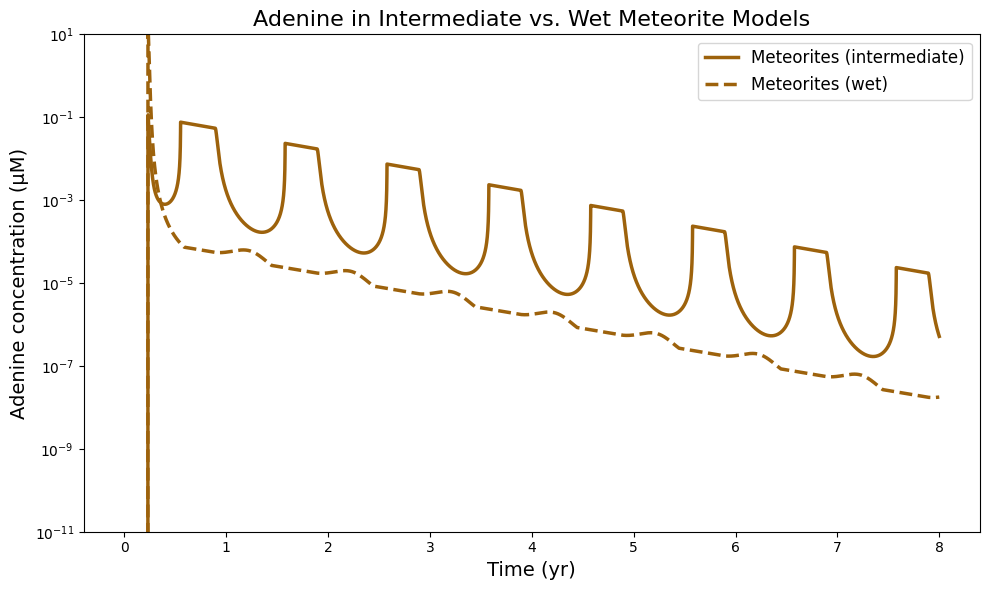

In [34]:
import matplotlib.pyplot as plt

# After running your simulation loop, compute adenine concentrations for the two meteorite scenarios:
#   adenine.mass[:] holds the mass in the “adenine” object
#   m_IDN_65_Met[:] and m_COL_65_Met[:] are the corresponding pond water masses

C_IDN = adenine.mass / m_IDN_65_Met    # molar fraction or mass fraction depending on units
C_COL = adenine.mass / m_COL_65_Met

# Convert to micromolar: assume adenine.mass is in kg, convert to moles via mu_A, then to μM via pond volume
mu_A = 0.13513      # kg/mol
# pond volume = A_p * depth; here depth = r_p - L, so we could recompute volume array
# but if you prefer mass‐based conc (kg adenine per kg water), skip this step

# Simple plot on a log scale
plt.figure(figsize=(10,6))
plt.plot(t, C_IDN * 1e6 / mu_A,  label="Meteorites (intermediate)", lw=2.5, color="#9d620c")
plt.plot(t, C_COL * 1e6 / mu_A, "--", label="Meteorites (wet)", lw=2.5, color="#9d620c")

plt.yscale('log')
plt.ylim(1e-11, 1e1)

plt.xlabel("Time (yr)", fontsize=14)
plt.ylabel("Adenine concentration (μM)", fontsize=14)
plt.title("Adenine in Intermediate vs. Wet Meteorite Models", fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
